In [1]:
!pip install datasets
!pip install matplotlib
!pip install numpy
!pip install torch
!pip install tqdm
!pip install torchvision
!pip install wandb
!pip install cython
!pip install pycocotools
!pip install matplotlib

     |████████████████████████████████| 325 kB 10.2 MB/s 
     |████████████████████████████████| 1.1 MB 51.0 MB/s 
     |████████████████████████████████| 136 kB 45.3 MB/s 
     |████████████████████████████████| 212 kB 47.3 MB/s 
     |████████████████████████████████| 77 kB 6.5 MB/s 
     |████████████████████████████████| 127 kB 46.5 MB/s 
     |████████████████████████████████| 94 kB 1.7 MB/s 
     |████████████████████████████████| 144 kB 63.5 MB/s 
     |████████████████████████████████| 271 kB 41.8 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 1.8 MB 28.1 MB/s

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
cd /content/drive/MyDrive/Colab Notebooks/197_Assignment_2

/content/drive/MyDrive/Colab Notebooks/197_Assignment_2


In [4]:
import torch
import numpy as np
import wandb
import torchvision
import os

import label_utils
import utils
import transforms as T

from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image

from engine import train_one_epoch, evaluate
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [5]:
#wandb.login()
config = {
    "num_workers": 0,
    "pin_memory": False,
    "batch_size": 8,
    "dataset": "drinks",
    "train_split": "drinks/labels_train.csv",
    "test_split": "drinks/labels_test.csv",}
#run = wandb.init(project="197_Assignment_2", entity="arpm", config=config)

In [6]:
test_dict, test_classes = label_utils.build_label_dictionary(
    config['test_split'])
train_dict, train_classes = label_utils.build_label_dictionary(
    config['train_split'])

class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, root, dictionary, transform=None):
        self.dictionary = dictionary
        self.root = root
        self.transform = transform
        self.imgs = list(os.listdir(os.path.join(root, "drinks")))
    def __len__(self):
        return len(self.dictionary)

    def __getitem__(self, idx):

        key = list(self.dictionary.keys())[idx]
        img = Image.open(key)
        
        num_objs = len(self.dictionary[key])

        b_temp = self.dictionary[key]
        b_temp2 = [[j[i] for i in range(4)] for j in b_temp]  #remove class from value
        boxes = [[i[0], i[2], i[1], i[3]] for i in b_temp2] #in [xmin, ymin, xmax, ymax]

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.tensor([i[4] for i in b_temp], dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target['iscrowd'] = iscrowd

        if self.transform:
            img = self.transform(img)

        return img, target

train_split = ImageDataset("", train_dict, transforms.ToTensor())
test_split = ImageDataset("", test_dict, transforms.ToTensor())

print("Train split len:", len(train_split), train_split)
print("Test split len:", len(test_split), test_split)

train_loader = DataLoader(train_split,
                          batch_size=config['batch_size'],
                          shuffle=False,
                          num_workers=config['num_workers'],
                          pin_memory=config['pin_memory'],
                          collate_fn=utils.collate_fn)

test_loader = DataLoader(test_split,
                         batch_size=config['batch_size'],
                         shuffle=False,
                         num_workers=config['num_workers'],
                         pin_memory=config['pin_memory'],
                         collate_fn=utils.collate_fn)

Train split len: 996 <__main__.ImageDataset object at 0x7f44d11ddf90>
Test split len: 51 <__main__.ImageDataset object at 0x7f44c983df10>


In [7]:
def create_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
    return model

In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = create_model(4)
model.to(device)
model.load_state_dict(torch.load('model_weights.pth', map_location = device))
model.eval()
evaluate(model, test_loader, device=device)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

creating index...
index created!
Test:  [0/7]  eta: 0:06:09  model_time: 52.6268 (52.6268)  evaluator_time: 0.0152 (0.0152)  time: 52.7492  data: 0.1071
Test:  [6/7]  eta: 0:00:45  model_time: 49.4079 (45.6319)  evaluator_time: 0.0116 (0.0106)  time: 45.7442  data: 0.1010
Test: Total time: 0:05:20 (45.7449 s / it)
Averaged stats: model_time: 49.4079 (45.6319)  evaluator_time: 0.0116 (0.0106)
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.795
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.983
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.983
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.763
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.795
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all 

In [43]:
# use to pick one image from the test_split
#img, _ = test_split[42]
img = Image.open("sample_images/007.jpg")
img = transforms.functional.to_tensor(img)
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

boxes = prediction[0]['boxes']
labels = prediction[0]['labels']
img = img.swapaxes(0,1)
img = img.swapaxes(1,2)

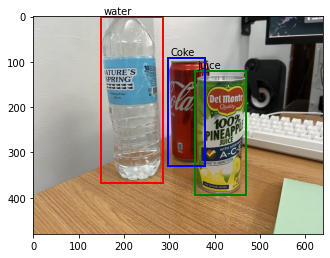

In [44]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
colors = ['w', 'r', 'b', 'g', 'c', 'm', 'y', 'g', 'c', 'm', 'k']
i = 0
fig, ax = plt.subplots(1)
plt.imshow(img)
for box in boxes:
  w = box[2] - box[0]
  h = box[3] - box[1]
  x = box[0]
  y = box[1]
  item_label = labels[i]
  color = colors[item_label]    #red = water, blue = coke, juice = green
  rect = Rectangle((x, y),
                         w,
                         h,
                         linewidth=2,
                         edgecolor=color,
                         facecolor='none')
  if (prediction[0]['scores'][i] > 0.80):   #only add bounding box when score is greater than 0.8
    ax.add_patch(rect)
    if (item_label == 1):
      ax.text(x+5, y-5, "water")
    if (item_label == 2):
      ax.text(x+5, y-5, "Coke")
    if (item_label == 3):
      ax.text(x+5, y-5, "juice")
  i += 1
plt.show()